## Alpha Factors

### Beta hedge

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import Markdown, display
from openbb import obb
from statsmodels import regression
obb.user.preferences.output_type = "dataframe"

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
symbols = ["NEM",
           "RGLD",
           "SSRM",
           "CDE",
           "LLY",
           "UNH",
           "JNJ",
           "MRK",
           "SPY"]

In [4]:
data = obb.equity.price.historical(symbols,
                                   start_date="2019-12-31",
                                   end_date="2024-12-31",
                                   provider="yfinance").pivot(columns="symbol", values="close")
data

symbol,CDE,JNJ,LLY,MRK,NEM,RGLD,SPY,SSRM,UNH
date,,,,,,,,,
2019-12-31,8.08,145.869995,131.429993,86.784348,43.450001,122.250000,321.859985,19.260000,293.980011
2020-01-02,7.81,145.970001,132.210007,87.824425,43.220001,121.120003,324.869995,18.969999,292.500000
2020-01-03,7.70,144.279999,131.770004,87.070610,42.830002,120.129997,322.410004,18.520000,289.540009
2020-01-06,6.93,144.100006,132.259995,87.442749,43.259998,118.809998,323.640015,18.370001,291.549988
2020-01-07,6.89,144.979996,132.509995,85.114502,43.230000,120.180000,322.730011,18.660000,289.790009
...,...,...,...,...,...,...,...,...,...
2024-12-24,5.84,145.850006,795.669983,99.449997,38.310001,133.320007,601.299988,7.150000,506.100006
2024-12-26,5.90,145.580002,794.140015,99.870003,38.090000,134.639999,601.340027,6.990000,511.149994
2024-12-27,5.77,145.050003,783.169983,99.699997,37.840000,133.830002,595.010010,7.060000,509.989990


In [5]:
benchmark_returns = data.pop("SPY").pct_change().dropna()

In [6]:
portfolio_returns = data.pct_change().dropna().sum(axis=1)

In [7]:
portfolio_returns.name = "portfolio"

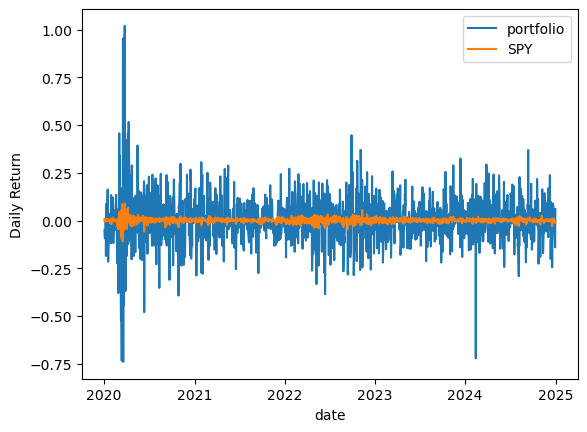

In [8]:
portfolio_returns.plot()
benchmark_returns.plot()
plt.ylabel("Daily Return")
plt.legend();

In [9]:
X = benchmark_returns.values
Y = portfolio_returns.values
def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    x = x[:, 1]
    return model.params[0], model.params[1]

In [10]:
alpha, beta = linreg(X, Y)
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: 0.0006257900422025403
Beta: 5.460073282508644


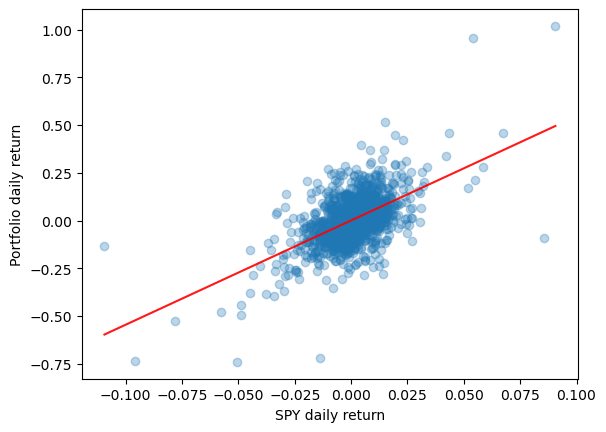

In [11]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha
plt.scatter(X, Y, alpha=0.3)
plt.xlabel("SPY daily return")
plt.ylabel("Portfolio daily return")
plt.plot(X2, Y_hat, "r", alpha=0.9);

In [12]:
hedged_portfolio_returns = -1 * beta * benchmark_returns + portfolio_returns

In [13]:
P = hedged_portfolio_returns.values
_, beta = linreg(X, P)
print(f"Beta: {beta}")

Beta: 2.7699197102659667e-15


In [14]:
def information_ratio(portfolio_returns, benchmark_returns):
    active_return = portfolio_returns - benchmark_returns
    tracking_error = active_return.std()
    return active_return.mean() / tracking_error

In [15]:
hedged_ir = information_ratio(hedged_portfolio_returns, benchmark_returns)
unhedged_ir = information_ratio(portfolio_returns, benchmark_returns)
print(f"Hedged information ratio: {hedged_ir}")
print(f"Unhedged information ratio: {unhedged_ir}")

Hedged information ratio: 0.0005579658937838048
Unhedged information ratio: 0.02551765752366138


### Fama French Factors

In [16]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from openbb import obb
import statsmodels.api as sm
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS
obb.user.preferences.output_type = "dataframe"

In [17]:
symbols = ["NEM",
           "RGLD",
           "SSRM",
           "CDE",
           "LLY",
           "UNH",
           "JNJ",
           "MRK",
           "SPY"]

In [18]:
data = obb.equity.price.historical(symbols,
                                   start_date="2015-12-31",
                                   end_date="2022-12-31",
                                   provider="yfinance").pivot(columns="symbol", values="close")
data

symbol,CDE,JNJ,LLY,MRK,NEM,RGLD,SPY,SSRM,UNH
date,,,,,,,,,
2015-12-31,2.48,102.720001,84.260002,50.400764,17.990000,36.470001,203.869995,5.18,117.639999
2016-01-04,2.47,100.480003,82.870003,50.076336,18.440001,37.180000,201.020004,5.18,116.459999
2016-01-05,2.38,100.900002,84.110001,50.715649,18.420000,36.490002,201.360001,5.11,116.680000
2016-01-06,2.38,100.389999,83.580002,50.019085,18.559999,37.020000,198.820007,5.20,115.489998
2016-01-07,2.43,99.220001,81.410004,49.580154,18.860001,38.740002,194.050003,5.24,112.089996
...,...,...,...,...,...,...,...,...,...
2022-12-23,3.43,177.479996,367.899994,111.860001,47.849998,112.839996,382.910004,15.95,531.309998
2022-12-27,3.69,177.429993,364.880005,112.120003,48.750000,114.410004,381.399994,16.34,531.989990
2022-12-28,3.47,176.660004,365.220001,111.080002,47.369999,111.500000,376.660004,15.70,528.450012


In [19]:
monthly_returns = data.asfreq("ME").dropna().pct_change(fill_method=None).to_period("M")
monthly_returns

symbol,CDE,JNJ,LLY,MRK,NEM,RGLD,SPY,SSRM,UNH
date,,,,,,,,,
2015-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02,0.556452,0.024241,-0.145502,-0.049413,0.435798,0.271456,-0.050571,0.119691,0.012411
2016-03,0.455959,0.028419,0.000139,0.053774,0.029036,0.106103,0.061790,-0.043103,0.082284
2016-05,0.339858,0.041497,0.041939,0.063315,0.219338,0.094365,0.021020,0.627027,0.037005
2016-06,0.415671,0.076404,0.049580,0.023996,0.207035,0.283093,-0.001716,0.438538,0.056333
2016-08,0.195122,-0.016158,-0.012698,0.089915,-0.022495,0.018051,0.037712,-0.097767,-0.036473
2016-09,-0.071429,-0.010139,0.032283,-0.006052,0.027458,0.056056,-0.004968,0.029010,0.029033
2016-10,-0.054945,-0.018116,-0.079990,-0.059125,-0.057266,-0.111197,-0.017337,-0.091211,0.009500
2016-11,-0.136852,-0.040434,-0.091008,0.042064,-0.124190,0.011915,0.036838,-0.100365,0.120215


In [20]:
bench = monthly_returns.pop("SPY")
R = monthly_returns.mean(axis=1)
active = (R - bench).dropna()

In [21]:
factors = pdr.get_data_famafrench("F-F_Research_Data_Factors",
                                  start="2014-12-31",
                                  end="2022-12-31")[0][1:] / 100

In [22]:
factors.index

PeriodIndex(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
             '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
             '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
             '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
             '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
             '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
             '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
             '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
             '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
             '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
             '2021-01', '2021-02', '2021-03', '2021-

In [23]:
active.index

PeriodIndex(['2016-02', '2016-03', '2016-05', '2016-06', '2016-08', '2016-09',
             '2016-10', '2016-11', '2017-01', '2017-02', '2017-03', '2017-05',
             '2017-06', '2017-07', '2017-08', '2017-10', '2017-11', '2018-01',
             '2018-02', '2018-04', '2018-05', '2018-07', '2018-08', '2018-10',
             '2018-11', '2018-12', '2019-01', '2019-02', '2019-04', '2019-05',
             '2019-07', '2019-09', '2019-10', '2019-12', '2020-01', '2020-03',
             '2020-04', '2020-06', '2020-07', '2020-08', '2020-09', '2020-11',
             '2020-12', '2021-03', '2021-04', '2021-06', '2021-08', '2021-09',
             '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-05',
             '2022-06', '2022-08', '2022-09', '2022-10', '2022-11'],
            dtype='period[M]', name='date')

In [24]:
SMB = factors.loc[active.index, "SMB"]
HML = factors.loc[active.index, "HML"]

In [25]:
df = pd.DataFrame({"R": active, "SMB": SMB, "HML": HML}, index=active.index).dropna()

In [26]:
b1, b2 = regression.linear_model.OLS(df.R, df[["SMB", "HML"]]).fit().params

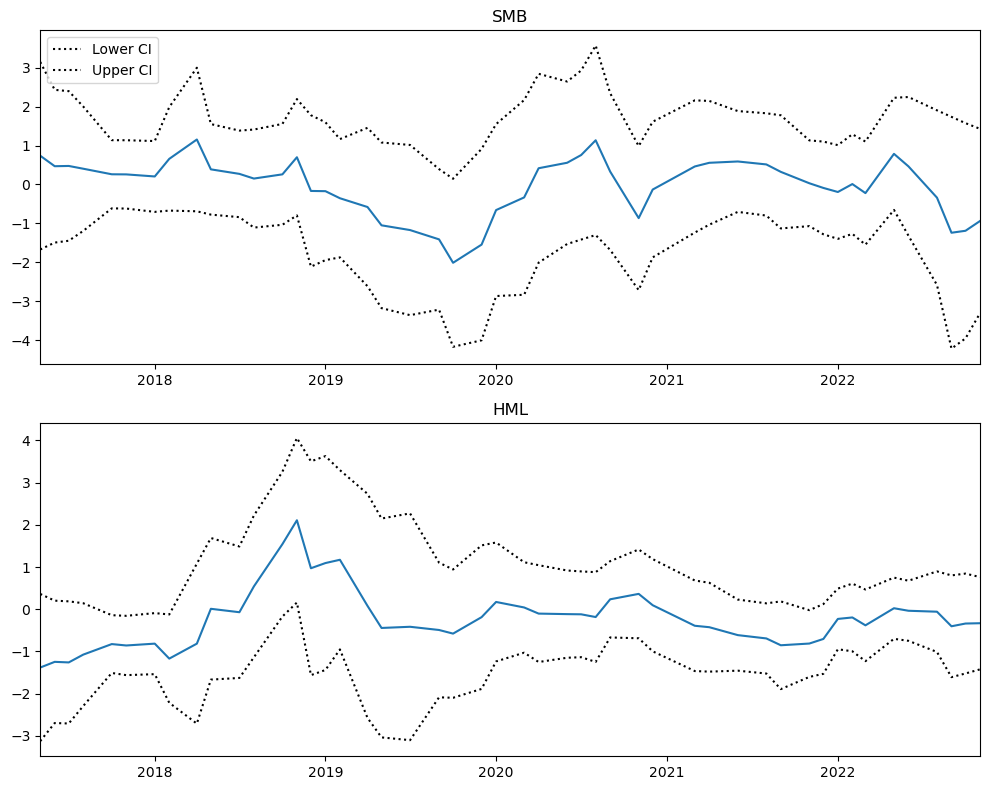

In [27]:
exog = sm.add_constant(df[["SMB", "HML"]])
rols = RollingOLS(active, exog, window=12)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=["SMB", "HML"], figsize=(10, 8))

### Marginal Contribution to Active Risk

In [28]:
F1 = df.SMB
F2 = df.HML
cov = np.cov(F1, F2)
r_squared = (active.std()) ** 2
mcar1 = (b1 * (b2 * cov[0, 1] + b1 * cov[0, 0])) / r_squared
mcar2 = (b2 * (b1 * cov[0, 1] + b2 * cov[1, 1])) / r_squared
print(f"SMB risk contribution: {mcar1}")
print(f"HML risk contribution: {mcar2}")
print(f"Unexplained risk contribution: {1 - (mcar1 + mcar2)}")

SMB risk contribution: 0.0038897639284747286
HML risk contribution: 0.01733960942065409
Unexplained risk contribution: 0.9787706266508712


In [29]:
covariances = df[["SMB", "HML"]].rolling(window=12).cov().dropna()

In [30]:
active_risk_squared = (active.rolling(window=12).std() ** 2).dropna()

In [31]:
betas = pd.concat([rres.params.SMB, rres.params.HML], axis=1).dropna()

In [32]:
MCAR = pd.DataFrame(index=betas.index, columns=betas.columns)

In [33]:
for factor in betas.columns:
    for t in betas.index:
        s = np.sum(betas.loc[t] * covariances.loc[t][factor])
        b = betas.loc[t][factor]
        AR = active_risk_squared.loc[t]
        MCAR[factor][t] = b * s / AR

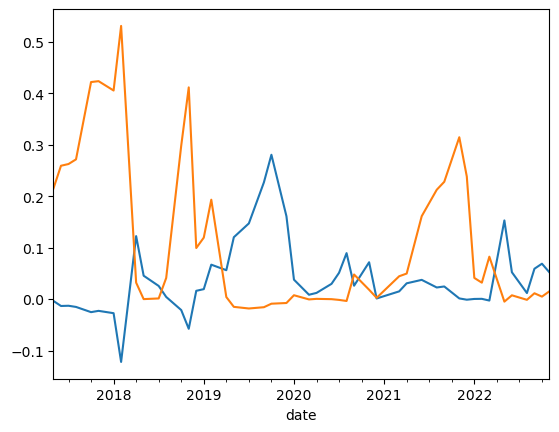

In [34]:
MCAR.SMB.plot()
MCAR.HML.plot();

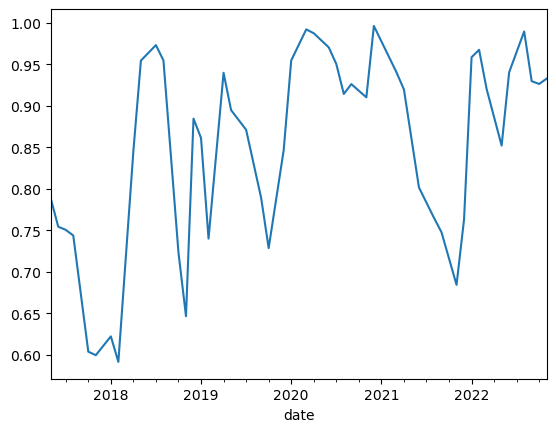

In [35]:
(1 - (MCAR.SMB + MCAR.HML)).plot();

### Principal Component Analysis

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from openbb import obb
from sklearn.decomposition import PCA
obb.user.preferences.output_type = "dataframe"

In [37]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK"]
data = obb.equity.price.historical(symbols,
                                   start_date="2020-01-01",
                                   end_date="2024-12-31",
                                   provider="yfinance").pivot(columns="symbol", values="close")
returns = data.pct_change().dropna()
pca = PCA(n_components=3)
pca.fit(returns)

PCA(n_components=3)

In [38]:
pct = pca.explained_variance_ratio_
pca_components = pca.components_

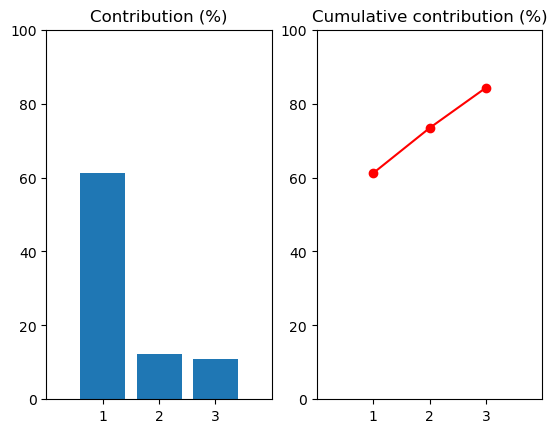

In [39]:
cum_pct = np.cumsum(pct)
x = np.arange(1, len(pct) + 1, 1)
plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title("Contribution (%)")
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])
plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, "ro-")
plt.title("Cumulative contribution (%)")
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100]);

In [40]:
X = np.asarray(returns)
factor_returns = X.dot(pca_components.T)
factor_returns = pd.DataFrame(columns=["f1", "f2", "f3"],
                              index=returns.index,
                              data=factor_returns)
factor_returns

,f1,f2,f3
date,,,
2020-01-03,-0.028841,-0.001885,-0.017114
2020-01-06,-0.080381,0.029295,0.049296
2020-01-07,0.004558,0.020775,0.003402
2020-01-08,-0.105654,-0.004805,0.027515
2020-01-09,0.000308,-0.032439,-0.011423
...,...,...,...
2024-12-24,0.002581,0.003655,0.004206
2024-12-26,-0.000429,-0.020425,-0.009894
2024-12-27,-0.017168,0.020864,0.003446


In [41]:
factor_exposures = pd.DataFrame(index=["f1", "f2", "f3"],
                                columns=returns.columns,
                                data=pca_components).T
factor_exposures

,f1,f2,f3
symbol,,,
CDE,0.772337,-0.393851,-0.471055
JNJ,0.044838,-0.198483,0.259259
LLY,0.045061,-0.438274,0.494566
MRK,0.052951,-0.267412,0.283794
NEM,0.299278,0.151991,0.163107
RGLD,0.295710,0.155869,0.145174
SSRM,0.462887,0.607796,0.418044
UNH,0.073307,-0.353666,0.404125


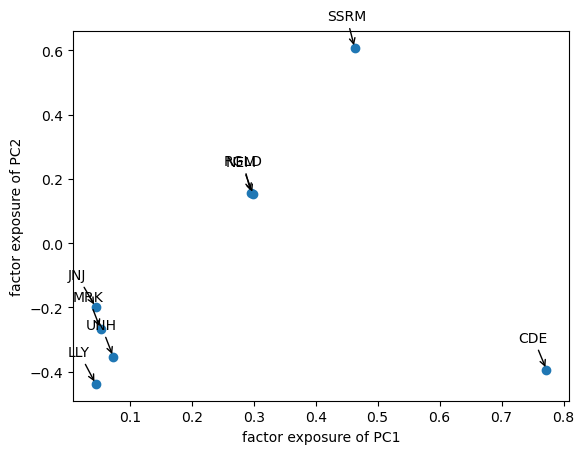

In [42]:
labels = factor_exposures.index
data = factor_exposures.values
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel("factor exposure of PC1")
plt.ylabel("factor exposure of PC2")
for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(-20, 20),
                 textcoords="offset points",
                 arrowprops=dict(arrowstyle="->",
                                 connectionstyle="arc3, rad=0"))

### Market Inefficiency

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openbb import obb
from scipy.stats import spearmanr
obb.user.preferences.output_type = "dataframe"

In [44]:
symbols = ["NEM",
           "RGLD",
           "SSRM",
           "CDE",
           "LLY",
           "UNH",
           "JNJ",
           "MRK"]

In [45]:
data = obb.equity.price.historical(symbols,
                                   start_date="2015-01-01",
                                   end_date="2024-12-31",
                                   provider="yfinance")
prices = data[["high", "low", "close", "volume", "symbol"]]
prices

,high,low,close,volume,symbol
date,,,,,
2015-01-02,5.300000,4.960000,5.300000,2864400,CDE
2015-01-02,105.550003,104.129997,104.519997,5753600,JNJ
2015-01-02,70.820000,69.720001,70.059998,3146200,LLY
2015-01-02,55.143131,54.417938,54.570610,7415962,MRK
2015-01-02,19.389999,18.600000,19.340000,6533500,NEM
...,...,...,...,...,...
2024-12-31,99.529999,98.430000,99.480003,6598200,MRK
2024-12-31,37.389999,36.860001,37.220001,9342600,NEM
2024-12-31,132.559998,131.000000,131.850006,194600,RGLD


In [46]:
nobs = prices.groupby("symbol").size()
mask = nobs[nobs > 2 * 12 *21].index
prices = prices[prices.symbol.isin(mask)]

In [47]:
prices = (prices
          .set_index("symbol", append=True)
          .reorder_levels(["symbol", "date"])
          .sort_index(level=0)
          .drop_duplicates())

In [48]:
prices

high         low       close   volume
symbol date                                                   
CDE    2015-01-02    5.300000    4.960000    5.300000  2864400
       2015-01-05    5.450000    5.140000    5.440000  2997000
       2015-01-06    5.730000    5.450000    5.690000  3885200
       2015-01-07    5.940000    5.470000    5.610000  4099700
       2015-01-08    5.850000    5.510000    5.600000  2903300
...                       ...         ...         ...      ...
UNH    2024-12-24  506.100006  500.589996  506.100006  1824400
       2024-12-26  512.219971  504.730011  511.149994  3387000
       2024-12-27  513.179993  507.799988  509.989990  3471800
       2024-12-30  509.730011  500.660004  507.799988  5408600
       2024-12-31  511.000000  503.339996  505.859985  4214000

[20128 rows x 4 columns]

In [49]:
def parkinson(data, window=14, trading_days=252):
    rs = (1.0 / (4.0 * np.log(2.0))) * ((data.high / data.low).apply(np.log)) ** 2.0
    def f(v):
        return (trading_days * v.mean()) ** 0.5
    result = rs.rolling(window=window, center=False).apply(func=f)
    return result.sub(result.mean()).div(result.std())

In [50]:
prices["vol"] = prices.groupby("symbol", group_keys=False).apply(parkinson)
prices.dropna(inplace=True)
prices

high         low       close   volume       vol
symbol date                                                             
CDE    2015-01-22    6.430000    6.150000    6.310000  3404900  0.572958
       2015-01-23    6.250000    5.930000    5.990000  2234000  0.533757
       2015-01-26    6.130000    5.690000    6.110000  2149800  0.584505
       2015-01-27    6.420000    6.120000    6.320000  3697700  0.579275
       2015-01-28    6.360000    5.890000    5.990000  2668300  0.557754
...                       ...         ...         ...      ...       ...
UNH    2024-12-24  506.100006  500.589996  506.100006  1824400  2.015222
       2024-12-26  512.219971  504.730011  511.149994  3387000  1.686950
       2024-12-27  513.179993  507.799988  509.989990  3471800  1.198297
       2024-12-30  509.730011  500.660004  507.799988  5408600  1.105863
       2024-12-31  511.000000  503.339996  505.859985  4214000  1.089465

[20024 rows x 5 columns]

In [51]:
lags = [1, 5, 10, 21, 42, 63]
for lag in lags:
    prices[f"return_{lag}d"] = prices.groupby(level="symbol").close.pct_change(lag)

In [52]:
for t in [1, 5, 10, 21, 42, 63]:
    prices[f"target_{t}d"] = prices.groupby(level="symbol")[f"return_{t}d"].shift(-t)

In [53]:
display(prices)

high         low       close   volume       vol  \
symbol date                                                                
CDE    2015-01-22    6.430000    6.150000    6.310000  3404900  0.572958   
       2015-01-23    6.250000    5.930000    5.990000  2234000  0.533757   
       2015-01-26    6.130000    5.690000    6.110000  2149800  0.584505   
       2015-01-27    6.420000    6.120000    6.320000  3697700  0.579275   
       2015-01-28    6.360000    5.890000    5.990000  2668300  0.557754   
...                       ...         ...         ...      ...       ...   
UNH    2024-12-24  506.100006  500.589996  506.100006  1824400  2.015222   
       2024-12-26  512.219971  504.730011  511.149994  3387000  1.686950   
       2024-12-27  513.179993  507.799988  509.989990  3471800  1.198297   
       2024-12-30  509.730011  500.660004  507.799988  5408600  1.105863   
       2024-12-31  511.000000  503.339996  505.859985  4214000  1.089465   

                   return_1d  return_5d  return_10d  return_21d  return_42d  \
symbol date                                                                   
CDE    2015-01-22        NaN        NaN         NaN         NaN         NaN   
       2015-01-23  -0.050713        NaN         NaN         NaN         NaN   
       2015-01-26   0.020033        NaN         NaN         NaN         NaN   
       2015-01-27   0.034370        NaN         NaN         NaN         NaN   
       2015-01-28  -0.052215        NaN         NaN         NaN         NaN   
...                      ...        ...         ...         ...         ...   
UNH    2024-12-24  -0.000474   0.042388   -0.104549   -0.143466   -0.097555   
       2024-12-26   0.009978   0.022873   -0.041947   -0.156281   -0.094605   
       2024-12-27  -0.002269   0.042391   -0.011187   -0.159528   -0.097746   
       2024-12-30  -0.004294   0.015336   -0.024362   -0.165324   -0.096650   
       2024-12-31  -0.003820  -0.000948    0.014764   -0.170993   -0.101428   

                   return_63d  target_1d  target_5d  target_10d  target_21d  \
symbol date                                                                   
CDE    2015-01-22         NaN  -0.050713  -0.058637    0.145800   -0.083994   
       2015-01-23         NaN   0.020033   0.051753    0.170284   -0.083472   
       2015-01-26         NaN   0.034370   0.045826    0.189853   -0.094926   
       2015-01-27         NaN  -0.052215   0.036392    0.136076   -0.115506   
       2015-01-28         NaN  -0.008347   0.188648    0.158598   -0.025042   
...                       ...        ...        ...         ...         ...   
UNH    2024-12-24   -0.121827   0.009978        NaN         NaN         NaN   
       2024-12-26   -0.110750  -0.002269        NaN         NaN         NaN   
       2024-12-27   -0.123503  -0.004294        NaN         NaN         NaN   
       2024-12-30   -0.131491  -0.003820        NaN         NaN         NaN   
       2024-12-31   -0.132762        NaN        NaN         NaN         NaN   

                   target_42d  target_63d  
symbol date                                
CDE    2015-01-22   -0.133122   -0.118859  
       2015-01-23   -0.118531   -0.136895  
       2015-01-26   -0.147300   -0.067103  
       2015-01-27   -0.202532   -0.106013  
       2015-01-28   -0.191987   -0.086811  
...                       ...         ...  
UNH    2024-12-24         NaN         NaN  
       2024-12-26         NaN         NaN  
       2024-12-27         NaN         NaN  
       2024-12-30         NaN         NaN  
       2024-12-31         NaN         NaN  

[20024 rows x 17 columns]

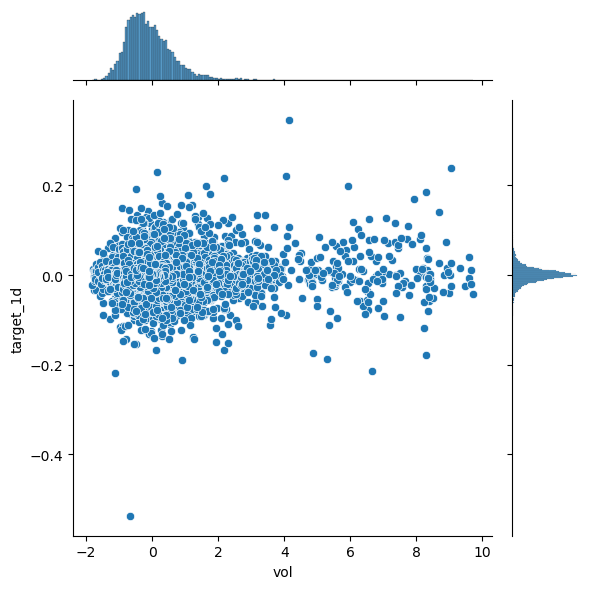

In [54]:
target = "target_1d"
metric = "vol"
j = sns.jointplot(x=metric, y=target, data=prices)
plt.tight_layout()
df = prices[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])

In [55]:
stat, pvalue = spearmanr(df[metric], df[target])

In [56]:
stat

0.023723728478882017

In [57]:
pvalue

0.0007889395038421867

### Factor Ranking

In [58]:
import os
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from zipline.data.bundles.core import load
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.factors import (
    VWAP,
    AnnualizedVolatility,
    AverageDollarVolume,
    BollingerBands,
    CustomFactor,
    DailyReturns,
    ExponentialWeightedMovingAverage,
    MaxDrawdown,
    PercentChange,
    Returns,
    SimpleMovingAverage,
    WeightedAverageValue
)

In [59]:
import warnings
warnings.simplefilter("ignore")

In [60]:
os.environ["QUANDL_API_KEY"] = "yFrqjBUBaLV_khbkKfCs"
bundle = "quandl"

In [61]:
bundle_data = load(bundle, os.environ, None)

In [62]:
display(bundle_data)

BundleData(asset_finder=<zipline.assets.assets.AssetFinder object at 0x000002070985BA90>, equity_minute_bar_reader=<zipline.data.bcolz_minute_bars.BcolzMinuteBarReader object at 0x0000020709840430>, equity_daily_bar_reader=<zipline.data.bcolz_daily_bars.BcolzDailyBarReader object at 0x000002070B712410>, adjustment_reader=<zipline.data.adjustments.SQLiteAdjustmentReader object at 0x000002070B74F280>)

In [63]:
pipeline_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader,
                                        bundle_data.adjustment_reader, fx_reader=None)

In [64]:
engine = SimplePipelineEngine(get_loader=lambda col: pipeline_loader, asset_finder=bundle_data.asset_finder)

In [65]:
class MomentumFactor(CustomFactor):
    inputs = [USEquityPricing.close, Returns(window_length=126)]
    window_length = 252

    def compute(self, today, assets, out, prices, returns):
        out[:] = ((prices[-21] - prices[-252]) / prices[-252]
                  - (prices[-1] - prices[-21]) / prices[-21]) / np.nanstd(returns, axis=0)

In [66]:
def make_pipeline():
    momentum = MomentumFactor()
    dollar_volume = AverageDollarVolume(window_length=30)

    return Pipeline(
        columns={
            "factor": momentum,
            "longs": momentum.top(50),
            "shorts": momentum.bottom(50),
            "rank": momentum.rank()}, screen=dollar_volume.top(100))

In [67]:
results = engine.run_pipeline(make_pipeline(), pd.to_datetime("2012-01-04"), pd.to_datetime("2012-03-01"))

In [68]:
results.dropna(subset="factor", inplace=True)
results.index.names = ["date", "symbol"]
results.sort_values(by=["date", "factor"], inplace=True)

In [69]:
display(results)

factor  longs  shorts    rank
date       symbol                                              
2012-01-04 Equity(300 [BAC])   -2.522045  False   False   165.0
           Equity(1264 [GS])   -2.215784  False   False   220.0
           Equity(1888 [MS])   -2.204802  False   False   225.0
           Equity(1894 [MSFT]) -1.949654  False   False   295.0
           Equity(457 [C])     -1.830819  False   False   345.0
...                                  ...    ...     ...     ...
2012-03-01 Equity(3105 [WMT])   3.409414  False   False  2607.0
           Equity(1690 [LLY])   3.809608  False   False  2642.0
           Equity(399 [BMY])    4.689588   True   False  2685.0
           Equity(1770 [MCD])   4.816880   True   False  2691.0
           Equity(1789 [MDLZ])  5.680276   True   False  2706.0

[4000 rows x 4 columns]